# Stacked Regression Model, Top 19% Best Solution

This code is the summary of my kernel posted on Kaggle, over the House Prices: Advanced Regression Techniques Challenge: https://www.kaggle.com/wesleyjr01/descomplicated-stacked-regression-kernel-top-19

In this code we will build a Machine Learning model based on Ensambling many ML models for final answer.

In [2]:
#Import some usefull libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import math
from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings("ignore")

In [3]:
#Importing the dataset to train our models, and the dataset to make predictions
df_train = pd.read_csv('C:/House Prices Advanced Regression Techniques/train.csv')
df_pred = pd.read_csv('C:/House Prices Advanced Regression Techniques/test.csv')

In [4]:
#DATA INFORMATION - Lets see how the training data looks like
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
#I will define here some variables to use in the course of work.
copy_df_train = df_train.copy()
copy_df_pred = df_pred.copy()
target = 'SalePrice'
identifier = 'Id'
test_size = 0.3
feature_transform = 1 #Flag variable
Norm_Features = 1 #Flag variable

* X_train : Will be the train data Matrix used to train our models
* X_teste = Will be the test data Matrix used to test our models
* X_pred = Will be the data Matrix used to make predicition and write them down to csv.

### Checking for Outliers:

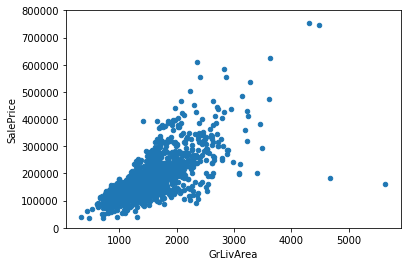

In [7]:
### Outliers ###
var = 'GrLivArea'
data = pd.concat([df_train[target], df_train[var]], axis=1)
data.plot.scatter(x=var, y=target, ylim=(0,800000));

#It looks like there are two point pretty off the curve SalePrice/GrLivArea, lets remove them
df_train = df_train.drop(df_train.index[df_train.sort_values(by=['GrLivArea'],ascending=False)[:2].index])

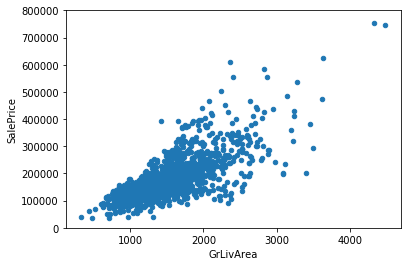

In [8]:
#Lets take a look at it without these outliers:
var = 'GrLivArea'
data = pd.concat([df_train[target], df_train[var]], axis=1)
data.plot.scatter(x=var, y=target, ylim=(0,800000));

### Merge Datasets Before Preprocessing the Data

In [9]:
#Define some usefull variables
train_Id = df_train[identifier]
pred_Id = df_pred[identifier]
train_target = df_train[target]
# Merge Train and Prediction Dataset into df_merge. Drop 'Id' and 'SalePrice' columns before merge
df_merge = pd.concat([df_train.drop([target,identifier],1),df_pred.drop(identifier,1)],axis=0)
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2917 entries, 0 to 1458
Data columns (total 79 columns):
MSSubClass       2917 non-null int64
MSZoning         2913 non-null object
LotFrontage      2431 non-null float64
LotArea          2917 non-null int64
Street           2917 non-null object
Alley            198 non-null object
LotShape         2917 non-null object
LandContour      2917 non-null object
Utilities        2915 non-null object
LotConfig        2917 non-null object
LandSlope        2917 non-null object
Neighborhood     2917 non-null object
Condition1       2917 non-null object
Condition2       2917 non-null object
BldgType         2917 non-null object
HouseStyle       2917 non-null object
OverallQual      2917 non-null int64
OverallCond      2917 non-null int64
YearBuilt        2917 non-null int64
YearRemodAdd     2917 non-null int64
RoofStyle        2917 non-null object
RoofMatl         2917 non-null object
Exterior1st      2916 non-null object
Exterior2nd      2916 non

In [10]:
#Take a look of the missing variables values of the df_merge DataFrame
total = df_merge.isnull().sum().sort_values(ascending=False)
percent = (df_merge.isnull().sum()/df_merge.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(40)

,Total,Percent
PoolQC,2908,0.996915
MiscFeature,2812,0.964004
Alley,2719,0.932122
Fence,2346,0.804251
FireplaceQu,1420,0.486802
LotFrontage,486,0.166610
GarageCond,159,0.054508
GarageQual,159,0.054508
GarageYrBlt,159,0.054508
GarageFinish,159,0.054508


### Dealing with Missing Data

One approach to deal with missing data is to drop the colums with a lot of data missing, wich in our case is PoolQC, MiscFeature, Alley and Fence, and then drop some exmaple lines of the rest NaN's values. (which I dont like very much, we might miss a lot of information by doing that)

Another approach is to perform Imputation into the numerical features, and get_dummies into the non-numeric variables.

In [11]:
# Separate object and non-object features
qualitative_features = [f for f in df_merge.dropna().columns if df_merge.dropna().dtypes[f] == 'object']
quantitative_features = [f for f in df_merge.dropna().columns if df_merge.dropna().dtypes[f] != 'object']

In [15]:
# Numeric Features Imputation
from __future__ import print_function
print('\n Is there any NaN value of numeric features in the dataset before Imputing?:'
      ,df_merge[quantitative_features].isnull().sum().any())
df_merge[quantitative_features].isnull().sum().sort_values(ascending=False)
df_merge['LotFrontage'] = df_merge['LotFrontage'].fillna(0)
df_merge['GarageYrBlt'] = df_merge['GarageYrBlt'].fillna(0)
df_merge['MasVnrArea'] = df_merge['MasVnrArea'].fillna(0)

for i in quantitative_features:
    df_merge[i] = df_merge[i].fillna(df_merge[i].mean())
    
# Normalization of Numeric Features
df_merge[quantitative_features] = (df_merge[quantitative_features]-df_merge[quantitative_features].min())/(
        df_merge[quantitative_features].max()-df_merge[quantitative_features].min())

print('\nIs there any NaN value of numeric features in the dataset after Imputing?:'
      ,df_merge[quantitative_features].isnull().sum().any())


 Is there any NaN value of numeric features in the dataset before Imputing?: True

Is there any NaN value of numeric features in the dataset after Imputing?: False


In [16]:
# NON-NUMERIC FEATURES
print('\nIs there any NaN value of non-numeric features in the dataset before Imputing?:'
      ,df_merge[qualitative_features].isnull().sum().any())

df_merge[qualitative_features].isnull().sum().sort_values(ascending=False)
df_merge['PoolQC'] = df_merge['PoolQC'].fillna('None')
df_merge['MiscFeature'] = df_merge['MiscFeature'].fillna('None')
df_merge['Alley'] = df_merge['Alley'].fillna('None')
df_merge['BsmtQual'] = df_merge['BsmtQual'].fillna('None')
df_merge['BsmtCond'] = df_merge['BsmtCond'].fillna('None')
df_merge['BsmtExposure'] = df_merge['BsmtCond'].fillna('None')
df_merge['BsmtFinType1'] = df_merge['BsmtFinType1'].fillna('None')
df_merge['BsmtFinType2'] = df_merge['BsmtFinType2'].fillna('None')
df_merge['FireplaceQu'] = df_merge['FireplaceQu'].fillna('None')
df_merge['GarageType'] = df_merge['GarageType'].fillna('None')
df_merge['GarageFinish'] = df_merge['GarageFinish'].fillna('None')
df_merge['GarageCond'] = df_merge['GarageCond'].fillna('None')
df_merge['GarageQual'] = df_merge['GarageQual'].fillna('None')
df_merge['Fence'] = df_merge['Fence'].fillna('None')
df_merge['MasVnrType'] = df_merge['MasVnrType'].fillna('None')
df_merge["Functional"] = df_merge["Functional"].fillna("Typ")
df_merge.drop('Utilities',axis=1,inplace=True)
last_qlfeat = ['MSZoning','KitchenQual','Exterior2nd','Exterior1st','Electrical','SaleType']
qualitative_features = [f for f in df_merge.dropna().columns 
                        if df_merge.dropna().dtypes[f] == 'object'] #List of Non-Numeric Features
quantitative_features = [f for f in df_merge.dropna().columns 
                         if df_merge.dropna().dtypes[f] != 'object'] #List of Numeric Features

for i in last_qlfeat:# Mode for the rest of non-numeric features
    df_merge[i] =  df_merge[i].fillna(df_merge[i].mode()[0])

print('\nIs there any NaN value  in the dataset after Imputing and get_dummies?:',df_merge.isnull().sum().any())


Is there any NaN value of non-numeric features in the dataset before Imputing?: True

Is there any NaN value  in the dataset after Imputing and get_dummies?: False


### Label Encoding Categorical Variables With Dummies

In [17]:
df_merge = pd.get_dummies(data=df_merge, columns=qualitative_features)

### Feature Transform - Log1p

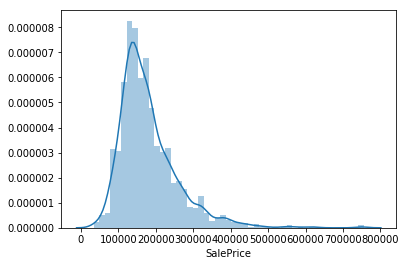

In [18]:
#There are some skewed variables which we can perform some log transformation
sns.distplot(df_train[target]) #SalePrice Distribution Plot
#SalePrice looks like this before log transformation
### FEATURE TRANSFORM - LOG1 of SalePrice ###
if feature_transform:
    train_target = np.log1p(train_target)

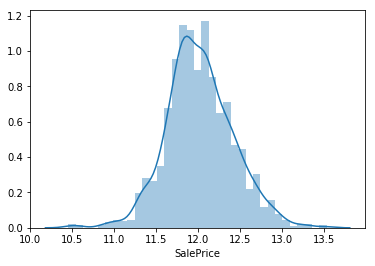

In [19]:
#SalePrice look like that after log transformation, much closer to a Normal Distr.
sns.distplot(np.log1p(df_train[target]))

In [20]:
# Restore datraframes df_train and df_pred
df_train = df_merge[:len(df_train)]
df_train[target] = train_target
df_pred = df_merge[len(df_train):]
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1458 entries, 0 to 1459
Columns: 300 entries, MSSubClass to SalePrice
dtypes: float64(37), uint8(263)
memory usage: 807.3 KB


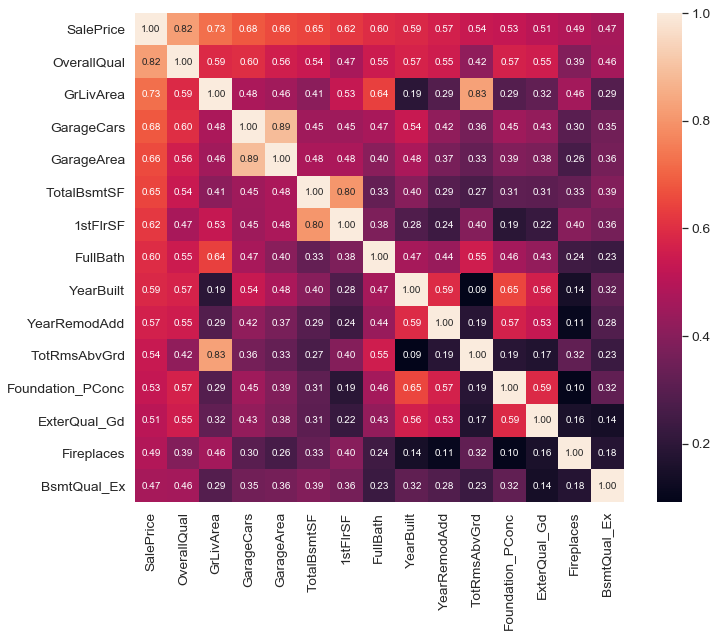

In [21]:
# Correlation Matrix to get a feeling of the correlations between variables on the dataset
corrmat = df_train.corr()
k = 15 #number of variables for heatmap
cols = corrmat.nlargest(k, target)[target].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
f, ax = plt.subplots(figsize=(12, 9))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

### Division between X_train,X_test,y_train,y_test

In [22]:
df_train = shuffle(df_train) #shuffle data before division
train_target = df_train[target] # Just for code readibility
predictors = df_train.drop([target], axis=1)
X_train, X_test, y_train, y_test = train_test_split(predictors, 
                                                    train_target,
                                                    train_size=1-test_size, 
                                                    test_size=test_size, 
                                                random_state=0)
X_pred = df_pred

### Lasso Model

In [24]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

lasso = make_pipeline(RobustScaler(),LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 
                          0.3, 0.6, 1, 3, 6, 10, 30, 60, 100], 
                max_iter = 50000, cv = 10))
lasso.fit(X_train, y_train)

y_train_las = lasso.predict(X_train)
y_test_las = lasso.predict(X_test)
las_prediction = lasso.predict(X_pred)

### Ridge Model

In [25]:
#RobustScaler() to make the model robust against outliers
ridge = make_pipeline(RobustScaler(),RidgeCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 
                          0.3, 0.6, 1, 3, 6, 10, 30, 60, 100]))
ridge.fit(X_train, y_train)

y_train_rdg = ridge.predict(X_train)
y_test_rdg = ridge.predict(X_test)
rdg_prediction = ridge.predict(X_pred)

### XGBoost Model through GridSearch

In [26]:
xgb_model = XGBRegressor()
params = {'n_estimators':[1000],'learning_rate':[0.1,0.05],
'max_depth':[3,4,5]}
grid = GridSearchCV(xgb_model, params)
grid.fit(X_train, y_train)
y_train_gridXGB = grid.best_estimator_.predict(X_train)
y_test_gridXGB = grid.best_estimator_.predict(X_test)
gridXGB_prediction = grid.best_estimator_.predict(X_pred)

### XGBoost Model without GridSearch

In [27]:
xgb_model = XGBRegressor(n_estimators=10000, learning_rate=0.05)

xgb_model.fit(X_train, y_train, early_stopping_rounds=5, 
             eval_set=[(X_test, y_test)], verbose=False)
  
y_train_xgb = xgb_model.predict(X_train)
y_test_xgb = xgb_model.predict(X_test)
xgb_prediction = xgb_model.predict(X_pred)

### ElasticNetRegression

In [28]:
from sklearn.linear_model import ElasticNetCV, ElasticNet
elnr = make_pipeline(RobustScaler(),ElasticNetCV(l1_ratio=[0.2,0.65],alphas=[0.001,0.005],n_jobs=-1,max_iter=3000))

elnr.fit(X_train,y_train)

y_train_eln = elnr.predict(X_train)
y_test_eln = elnr.predict(X_test)
eln_prediction = elnr.predict(X_pred)

### GradientBoost

In [30]:
from sklearn.ensemble import GradientBoostingRegressor
#With huber loss that makes it robust to outliers
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                    min_samples_split=10, 
                                   loss='huber', random_state =5)

GBoost.fit(X_train,y_train)

GBoost_train = GBoost.predict(X_train)
GBoost_test = GBoost.predict(X_test)
GBoost_prediction = GBoost.predict(X_pred)

### KernelRidge

In [31]:
from sklearn.kernel_ridge import KernelRidge
KR = KernelRidge(alpha=1.0)
KR.fit(X_train, y_train) 

y_train_KR = KR.predict(X_train)
y_test_KR = KR.predict(X_test)
KR_prediction = KR.predict(X_pred)

### LightGBM

In [32]:
import lightgbm as lgb
# other scikit-learn modules
estimator = lgb.LGBMRegressor(num_leaves=31)

param_grid = {
    'learning_rate': [0.001,0.005, 0.01],
    'n_estimators': [100,1000]}

gbm = GridSearchCV(estimator, param_grid)
gbm.fit(X_train, y_train)

y_train_gbm = gbm.predict(X_train)
y_test_gbm = gbm.predict(X_test)
gbm_prediction = gbm.predict(X_pred)

### Results Compilation and Plots

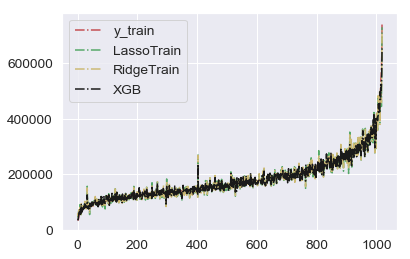

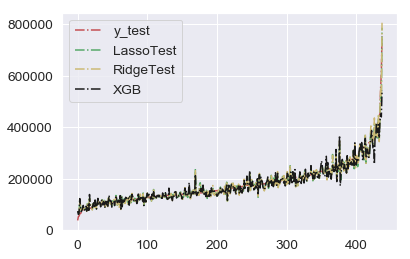

In [33]:
if feature_transform:
    y_train = np.expm1(y_train)
    y_test = np.expm1(y_test)

    
    y_train_las = np.expm1(y_train_las)
    y_test_las = np.expm1(y_test_las)
    las_prediction = np.expm1(las_prediction)
    
    y_train_rdg = np.expm1(y_train_rdg)
    y_test_rdg = np.expm1(y_test_rdg)
    rdg_prediction = np.expm1(rdg_prediction)
    
    y_train_xgb = np.expm1(y_train_xgb)
    y_test_xgb = np.expm1(y_test_xgb)
    xgb_prediction = np.expm1(xgb_prediction)
    
    y_train_gridXGB = np.expm1(y_train_gridXGB)
    y_test_gridXGB = np.expm1(y_test_gridXGB)
    gridXGB_prediction = np.expm1(gridXGB_prediction)

    
    y_train_eln = np.expm1(y_train_eln)
    y_test_eln = np.expm1(y_test_eln)
    eln_prediction = np.expm1(eln_prediction)
    
    GBoost_train = np.expm1(GBoost_train)
    GBoost_test = np.expm1(GBoost_test)
    GBoost_prediction = np.expm1(GBoost_prediction)
    
    y_train_KR = np.expm1(y_train_KR)
    y_test_KR = np.expm1(y_test_KR)
    KR_prediction = np.expm1(KR_prediction)
    
    y_train_gbm = np.expm1(y_train_gbm)
    y_test_gbm = np.expm1(y_test_gbm)
    gbm_prediction = np.expm1(gbm_prediction)
else:
    pass
feature_transform=0


df_resultado_treinamento = pd.DataFrame(
        {'x_train':list(X_train.values),
         'y_train':list(y_train),
         'y_train_lasso':y_train_las,
         'y_train_ridge':y_train_rdg,
         'y_train_xgb':y_train_xgb,
         'y_train_gridXGB':y_train_gridXGB,
         'y_train_eln':y_train_eln,
         'GBoost_train':GBoost_train,
         'y_train_KR':y_train_KR,
         'y_train_gbm':y_train_gbm,
                })
    
df_resultado_val = pd.DataFrame(
        {'x_val':list(X_test.values),
         'y_val':list(y_test),  
         'y_test_lasso':y_test_las,
         'y_test_ridge':y_test_rdg,
         'y_test_xgb':y_test_xgb,
         'y_test_gridXGB':y_test_gridXGB,
         'y_test_eln':y_test_eln,
         'GBoost_test':GBoost_test,
         'y_test_KR':y_test_KR,
         'y_test_gbm':y_test_gbm,
                })
    

plt.figure(1)

df_resultado_treinamento = df_resultado_treinamento.sort_values('y_train',ascending=1)
plt.plot(list(df_resultado_treinamento['y_train']),'r-.',label='y_train')
plt.plot(list(df_resultado_treinamento['y_train_lasso']),'g-.',label='LassoTrain')
plt.plot(list(df_resultado_treinamento['y_train_ridge']),'y-.',label='RidgeTrain')
plt.plot(list(df_resultado_treinamento['y_train_xgb']),'k-.',label='XGB')
plt.legend()


plt.figure(2)
df_resultado_val = df_resultado_val.sort_values('y_val',ascending=1)
plt.plot(list(df_resultado_val['y_val']),'r-.',label='y_test')
plt.plot(list(df_resultado_val['y_test_lasso']),'g-.',label='LassoTest')
plt.plot(list(df_resultado_val['y_test_ridge']),'y-.',label='RidgeTest')
plt.plot(list(df_resultado_val['y_test_xgb']),'k-.',label='XGB')
plt.legend()
plt.show()

### Evaluation of Models

In [34]:
## Models Eval
#### Root Mean Square Logarithmic Error ###
def logRMSE(y_test, y_pred) : 
    assert len(y_test) == len(y_pred)
    return np.sqrt(np.mean((np.log(1+y_pred) - np.log(1+y_test))**2))

print("\nLasso logRMSE on Training set :", logRMSE(y_train,y_train_las))
print("Ridge logRMSE on Training set :", logRMSE(y_train,y_train_rdg))
print("XGB logRMSE on Training set :", logRMSE(y_train,y_train_xgb))
print("gridXGB logRMSE on Training set :", logRMSE(y_train,y_train_gridXGB))



print("\nLasso logRMSE on Test set :", logRMSE(y_test,y_test_las))
print("Ridge logRMSE on Test set :", logRMSE(y_test,y_test_rdg))
print("XGB logRMSE on Test set :", logRMSE(y_test,y_test_xgb))
print("gridXGB logRMSE on Training set :", logRMSE(y_test,y_test_gridXGB))
print("eln logRMSE on Test set :", logRMSE(y_test,y_test_eln))
print("GBoost logRMSE on Test set :", logRMSE(y_test,GBoost_test))
print("KR logRMSE on Test set :", logRMSE(y_test,y_test_KR))
print("LightGBM logRMSE on Test set :", logRMSE(y_test,y_test_gbm))



print("StackedModel logRMSE on Test set :", logRMSE(y_test,(y_test_xgb+y_test_rdg+y_test_las + y_test_gridXGB
                                                            +y_test_eln + GBoost_test +y_test_KR +y_test_gbm)
                                                    /(len(df_resultado_val.columns)-2)))


Lasso logRMSE on Training set : 0.10001120347474576
Ridge logRMSE on Training set : 0.09569462884922753
XGB logRMSE on Training set : 0.0753644468355905
gridXGB logRMSE on Training set : 0.03752929533494506

Lasso logRMSE on Test set : 0.11043472278742247
Ridge logRMSE on Test set : 0.11339268013290296
XGB logRMSE on Test set : 0.11831880320146786
gridXGB logRMSE on Training set : 0.11523747366257055
eln logRMSE on Test set : 0.11071009772107318
GBoost logRMSE on Test set : 0.11559737345332112
KR logRMSE on Test set : 0.1321290142969437
LightGBM logRMSE on Test set : 0.12786240711832197
StackedModel logRMSE on Test set : 0.10758741334310726


As you can see, the **StackedModel** result performs better than the individuals. With this stacked submission, I scored 0.12151 on the public general score, **top 20% of ranking**. I hope this was usefull for you, enjoy!